# Objetivo: Classificar as imagens do Dataset CIFAR10.

Usaremos o dataset já incluído no tensorflow. Esse Dataset possui imagens coloridas.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout
from tensorflow.keras.layers import GlobalMaxPooling2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Sequential

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession


# Permite à GPU alocar mais memória para o tensorflow
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [2]:
# Importando os dados

cifar10 = tf.keras.datasets.cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train, x_test = x_train/255.0, x_test/255.0 # Normalização
y_train, y_test = y_train.flatten(), y_test.flatten() # O shape do Y está como (N, 1). Precisamos dele como (N,)

print("Dimensão do meu X de treinamento:", x_train.shape) # A diferença é que a dimensão de cores agora tem valor 3 
                                                          # (rgb), pois não são mais imagens em preto e branco como 
                                                          # as imagens do MNIST dataset.
print("Dimensão do meu Y de treinamento:", y_train.shape)

Dimensão do meu X de treinamento: (50000, 32, 32, 3)
Dimensão do meu Y de treinamento: (50000,)


In [3]:
# Nümero de classes

n_classes = len(set(y_train))
print("Número de classes:", n_classes)

Número de classes: 10


In [4]:
# Construindo a CNN (aplicando a técnica de Strided Convolutions)

# Modelo Antigo

# model = Sequential([
#     Input(shape=x_train[0].shape),
#     Conv2D(32, (3, 3), strides=2, activation='relu'),
#     Conv2D(64, (3, 3), strides=2, activation='relu'),
#     Conv2D(128, (3, 3), strides=2, activation='relu'),
#     Flatten(),
#     Dropout(0.5),
#     Dense(1024, activation='relu'),
#     Dropout(0.2),
#     Dense(n_classes, activation='softmax')
# ])


# Novo modelo otimizado
# Para imagens pequenas, MaxPooling funciona bem ao invés de StridedConvolutions.
# Nesse modelo, temos múltiplas convolutions (2) antes do pooling.
# Adicionamos também uma BatchNorm() após cada convolution.

model = Sequential([
    Input(shape=x_train[0].shape),
    
    Conv2D(32, (3, 3), activation='relu', padding='same'), # Tamanho dos filter maps após o padding: mesmo da img.
    BatchNormalization(), # Normalizando os valores dos inputs da camada, calculando a norm. em batches dos dados.
    
    Conv2D(32, (3, 3), activation='relu', padding='same'), 
    BatchNormalization(), 
    MaxPooling2D((2, 2)), # Tamanho do filtro do Pooling, pegando apenas os valores máximos dos filter maps (MaxPooling).
    
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dropout(0.2),
    Dense(1024, activation='relu'),
    Dropout(0.2),
    Dense(n_classes, activation='softmax')
])

In [5]:
# Compilando o modelo

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [6]:
# Treinando o modelo

# Fit feito sem data augmentation
# historico = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=15)
# Acurácia anterior: 77% na base de treino, 70% na base de teste


# Fit feito com data augmentation

batch_size = 32
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.1,  # Muda a horizont. da imagem,
                                                                 height_shift_range=0.1, # Muda a vertic. da imagem,
                                                                 horizontal_flip=True)   # Inverte a imagem
train_generator = data_generator.flow(x_train, y_train, batch_size)
steps_per_epoch = x_train.shape[0] // batch_size

historico = model.fit_generator(train_generator, validation_data=(x_test, y_test), epochs=10)

Epoch 1/10
1563/1563 [==============================] - 77s 49ms/step - loss: 1.4418 - accuracy: 0.4980 - val_loss: 3.2339 - val_accuracy: 0.3034
Epoch 2/10
1563/1563 [==============================] - 73s 47ms/step - loss: 1.0028 - accuracy: 0.6486 - val_loss: 0.9977 - val_accuracy: 0.6768
Epoch 3/10
1563/1563 [==============================] - 76s 48ms/step - loss: 0.8547 - accuracy: 0.7073 - val_loss: 0.9622 - val_accuracy: 0.6972
Epoch 4/10
1563/1563 [==============================] - 75s 48ms/step - loss: 0.7620 - accuracy: 0.7398 - val_loss: 0.7420 - val_accuracy: 0.7521
Epoch 5/10
1563/1563 [==============================] - 73s 47ms/step - loss: 0.6960 - accuracy: 0.7620 - val_loss: 0.7306 - val_accuracy: 0.7584
Epoch 6/10
1563/1563 [==============================] - 78s 50ms/step - loss: 0.6429 - accuracy: 0.7798 - val_loss: 0.6501 - val_accuracy: 0.7893
Epoch 7/10
1563/1563 [==============================] - 73s 47ms/step - loss: 0.6023 - accuracy: 0.7941 - val_loss: 0.6445 -

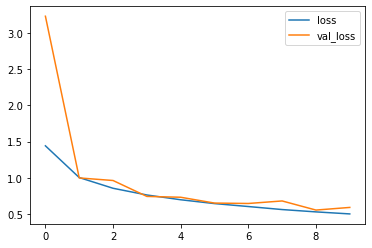

In [7]:
# Plotando o valor da loss function por epoch

plt.plot(historico.history['loss'], label='loss')
plt.plot(historico.history['val_loss'], label='val_loss')
plt.legend()

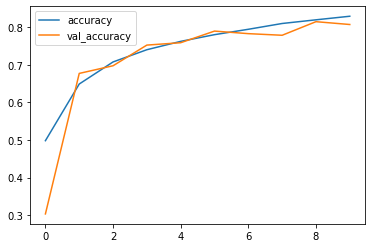

In [8]:
# Plotando o valor da acurácia por epoch

plt.plot(historico.history['accuracy'], label='accuracy')
plt.plot(historico.history['val_accuracy'], label='val_accuracy')
plt.legend()

Matriz de Confusão, sem normalização
[[895  15   9   7   2   1   1   6  58   6]
 [  7 958   0   0   0   0   2   1  13  19]
 [105  10 670  47  27  40  35  28  25  13]
 [ 35  15  30 679  27  85  36  42  31  20]
 [ 36   4  72  63 682  33  38  53  15   4]
 [ 17   7  26 142  18 708  16  45  18   3]
 [ 23   5  28  73   5  13 817   5  30   1]
 [ 20   4  10  22  26  24   4 880   7   3]
 [ 41  20   0   4   1   1   1   1 928   3]
 [ 24  95   1   2   0   0   0   1  26 851]]


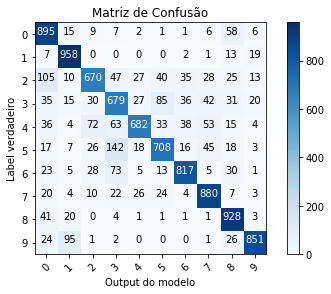

In [9]:
# Plotando a matriz de confusão desse modelo

from sklearn.metrics import confusion_matrix
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='Matriz de Confusão', cmap=plt.cm.Blues):
    # Essa função printa e plota a matriz de confusão.
    # A normalização pode ser aplicada setando 'normalize=True' nos parâmetros.
    
    if normalize:
        cm = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
        print("Matriz de Confusão normalizada")
    else:
        print("Matriz de Confusão, sem normalização")
    
    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('Label verdadeiro')
    plt.xlabel('Output do modelo')
    plt.show()
    
    
# Testando

pred_test = model.predict(x_test).argmax(axis=1)
cm = confusion_matrix(y_test, pred_test)
plot_confusion_matrix(cm, list(range(10)))


# Maior acurácia no modelo antigo: Caminhões
# Maior inacurácia no modelo antigo: Real - Gato, Prediction - Cachorro

# Maior acurácia no modelo novo: Carro
# Maior inacurácia no modelo novo: Real - Cachorro, Prediction - Gato

In [10]:
# Mapeando os labels

labels='''Aviao
Carro
Passaro
Gato
Veado
Cachorro
Sapo
Cavalo
Barco
Caminhao'''.split()

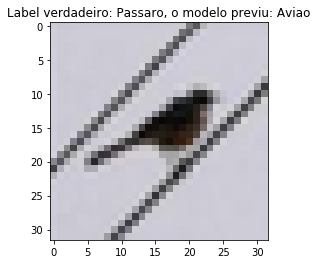

In [11]:
# Mostrando alguns exemplos errados

misclassified_idx = np.where(pred_test != y_test)[0] # Retorna onde pred_test é diferente do y_test
i = np.random.choice(misclassified_idx) # Seleciona um índice aleatoriamente
plt.imshow(x_test[i], cmap='gray') # Plota a imagem no índice aleatório
plt.title("Label verdadeiro: %s, o modelo previu: %s" % (labels[y_test[i]], labels[pred_test[i]]));

In [12]:
# Resumo da estrutura do modelo

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 64)        2